In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)

# Step 1: Load and preprocess the FER2013 dataset
data = pd.read_csv("fer2013.csv")
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
num_classes = len(data['emotion'].unique())
def CRNO(df, dataName):
    #df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel_sequence.split()])
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

 

train_X, train_Y = CRNO(data_train, "train")  # training data
val_X, val_Y = CRNO(data_val, "val")  # validation data
test_X, test_Y = CRNO(data_test, "test")  # test data
 
 

2024-05-19 23:00:53.893577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Step 2: Define the modified ResNet model
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    x = layers.Conv2D(filters * 4, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
        # Add residual and shortcut paths
    x = layers.add([x, shortcut])
    x = layers.Activation(swish)(x)
    return x

def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add 16 residual blocks
    filters = 64
    for i in range(16):
        if i % 4 == 0 and i != 0:
            filters *= 2
            x = residual_block(x, filters, stride=2)
        else:
            x = residual_block(x, filters, stride=1)

 
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation=swish)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

input_shape = (48, 48, 1)
base_model = build_resnet(input_shape)
build_resnet(input_shape)

# Step 3: Compile the model
base_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                   loss=losses.CategoricalCrossentropy(),
                   metrics=[metrics.CategoricalAccuracy()])

# Step 4: Set up callbacks
 
checkpoint_cb = callbacks.ModelCheckpoint("autodl-tmp/models/resnet/best_model.h5", save_best_only=True)
#checkpoint_cb = callbacks.ModelCheckpoint( filepath="best_model.h5",  save_best_only=True,  monitor='val_accuracy',  mode='max')                      )
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',  restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',patience=5,factor=0.75, verbose=1)


# Step 5: Train the model with data augmentation
history = base_model.fit(
    datagen.flow(train_X, train_Y, batch_size=64),
    epochs=150,
    validation_data=(val_X, val_Y),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


2024-05-19 23:01:13.029386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-19 23:01:13.068539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 23:01:13.068801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0e:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2024-05-19 23:01:13.068820: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-05-19 23:01:13.071772: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-19 23:01:13.071861: I tensorflow/stream_executor/pl

Epoch 1/150


2024-05-19 23:01:19.140192: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-19 23:01:19.747954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-05-19 23:01:20.493281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-19 23:01:20.991721: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-05-19 23:01:21.216852: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


449/449 [==============================] - 18s 26ms/step - loss: 1.9389 - categorical_accuracy: 0.2357 - val_loss: 1.8180 - val_categorical_accuracy: 0.2494


/root/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/150
449/449 [==============================] - 11s 23ms/step - loss: 1.8158 - categorical_accuracy: 0.2454 - val_loss: 1.8156 - val_categorical_accuracy: 0.2566
Epoch 3/150
449/449 [==============================] - 11s 23ms/step - loss: 1.7997 - categorical_accuracy: 0.2510 - val_loss: 1.7725 - val_categorical_accuracy: 0.2717
Epoch 4/150
449/449 [==============================] - 11s 23ms/step - loss: 1.7781 - categorical_accuracy: 0.2665 - val_loss: 1.7548 - val_categorical_accuracy: 0.2675
Epoch 5/150
449/449 [==============================] - 11s 23ms/step - loss: 1.7512 - categorical_accuracy: 0.2840 - val_loss: 1.7583 - val_categorical_accuracy: 0.2792
Epoch 6/150
449/449 [==============================] - 11s 24ms/step - loss: 1.7156 - categorical_accuracy: 0.2994 - val_loss: 1.6731 - val_categorical_accuracy: 0.3282
Epoch 7/150
449/449 [==============================] - 11s 23ms/step - loss: 1.6495 - categorical_accuracy: 0.3386 - val_loss: 1.5893 - val_categorical_acc

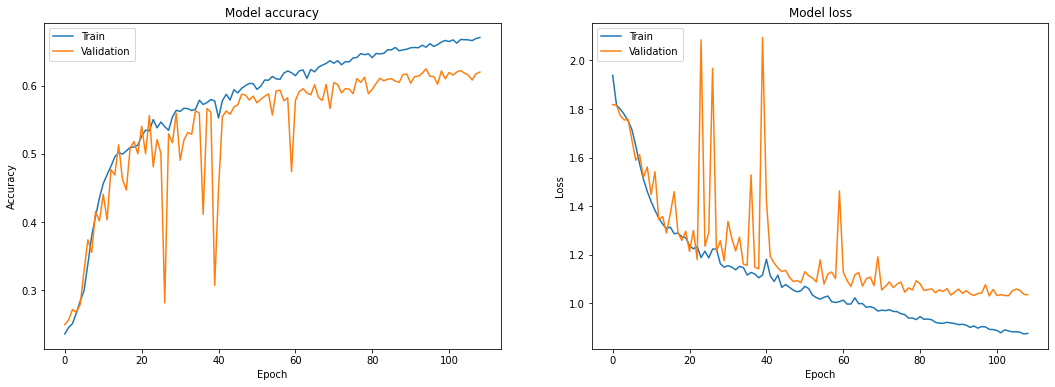

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 绘制训练和验证精度曲线
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# 绘制训练和验证损失曲线
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler
# Step 3: Combine ResNet with SVM classifier
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))
 
# 从多类别概率中获取单一目标标签
train_Y_labels = np.argmax(train_Y, axis=1)
val_Y_labels = np.argmax(val_Y, axis=1)
# Step 4: Train SVM classifier on ResNet features
train_features = base_model.predict(train_X)
val_features = base_model.predict(val_X)
test_features = base_model.predict(test_X)
# 使用 SVM 分类器进行训练
svm_classifier.fit(train_features, train_Y_labels)

# Step 9: Evaluate the SVM classifier on the test set
test_pred = svm_classifier.predict(test_features)
test_acc = accuracy_score(np.argmax(test_Y, axis=1), test_pred)
print(f'Test accuracy: {test_acc}')

# 保存整个模型
tf.keras.models.save_model(base_model, "autodl-tmp/models/resnet/resnet_svm_model-64.h5")

Test accuracy: 0.6238506547784898


/root/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
